Dataset Shape: (76014, 15)
First few rows:
   mid        date                  venue               bat_team  \
0    1  2008-04-18  M Chinnaswamy Stadium  Kolkata Knight Riders   
1    1  2008-04-18  M Chinnaswamy Stadium  Kolkata Knight Riders   
2    1  2008-04-18  M Chinnaswamy Stadium  Kolkata Knight Riders   
3    1  2008-04-18  M Chinnaswamy Stadium  Kolkata Knight Riders   
4    1  2008-04-18  M Chinnaswamy Stadium  Kolkata Knight Riders   

                     bowl_team      batsman   bowler  runs  wickets  overs  \
0  Royal Challengers Bangalore   SC Ganguly  P Kumar     1        0    0.1   
1  Royal Challengers Bangalore  BB McCullum  P Kumar     1        0    0.2   
2  Royal Challengers Bangalore  BB McCullum  P Kumar     2        0    0.2   
3  Royal Challengers Bangalore  BB McCullum  P Kumar     2        0    0.3   
4  Royal Challengers Bangalore  BB McCullum  P Kumar     2        0    0.4   

   runs_last_5  wickets_last_5  striker  non-striker  total  
0            1   

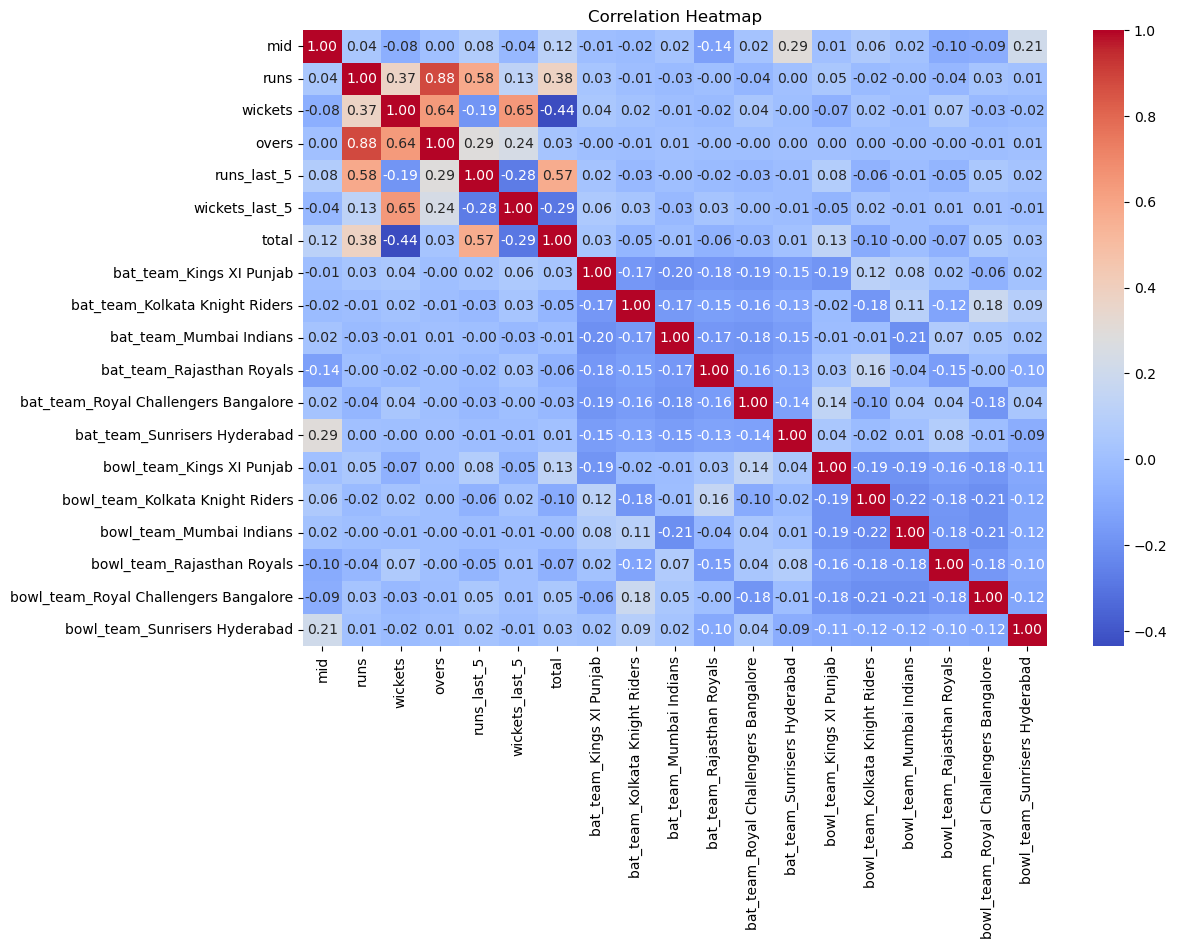

Linear Regression - MAE: 13.121796768114987, MSE: 314.72199662204054, RMSE: 17.740405762609843
Decision Tree - MAE: 1.648566095367385, MSE: 45.3325979976243, RMSE: 6.732948685206527
Random Forest - MAE: 2.152653996266757, MSE: 16.922267554725945, RMSE: 4.113668381715515
AdaBoost - MAE: 14.073339277423495, MSE: 336.4668274489508, RMSE: 18.343032122551353
Example Predictions:
Match 1 Predicted Score: 164.98
Match 2 Predicted Score: 172.84


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv("C:/Users/AMIT/Desktop/ipl.csv")

# Data exploration
print("Dataset Shape:", data.shape)
print("First few rows:")
print(data.head())

# Data preprocessing
# Remove unwanted columns
columns_to_remove = ['match_id', 'venue', 'batsman', 'bowler', 'striker', 'non-striker']
data = data.drop(columns=columns_to_remove, errors='ignore')

# Filter consistent teams
consistent_teams = [
    'Chennai Super Kings', 'Delhi Capitals', 'Kings XI Punjab',
    'Kolkata Knight Riders', 'Mumbai Indians', 'Rajasthan Royals',
    'Royal Challengers Bangalore', 'Sunrisers Hyderabad'
]
data = data[(data['bat_team'].isin(consistent_teams)) & (data['bowl_team'].isin(consistent_teams))]

# Remove data from the first 5 overs
data = data[data['overs'] >= 5.0]

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Drop the 'date' column from the feature set
data = data.drop(columns=['date'])

# One-hot encode categorical features
data = pd.get_dummies(data, columns=['bat_team', 'bowl_team'], drop_first=True)

# Splitting data into features and target
X = data.drop(columns=['total'])
y = data['total']

# Handle missing values in features
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model building and evaluation
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(estimator=LinearRegression(), random_state=42)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[model_name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
    print(f"{model_name} - MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

# Select the best model (Linear Regression for simplicity)
final_model = LinearRegression()
final_model.fit(X_train, y_train)

# Example predictions for specific matches
example_matches = pd.DataFrame([
    {
        'overs': 13.0, 'runs': 102, 'wickets': 3, 'runs_last_5': 35, 'wickets_last_5': 1,
        'bat_team_Chennai Super Kings': 1, 'bat_team_Kolkata Knight Riders': 0,
        'bowl_team_Mumbai Indians': 1, 'bowl_team_Rajasthan Royals': 0
    },
    {
        'overs': 17.0, 'runs': 150, 'wickets': 5, 'runs_last_5': 50, 'wickets_last_5': 2,
        'bat_team_Sunrisers Hyderabad': 1, 'bat_team_Delhi Capitals': 0,
        'bowl_team_Royal Challengers Bangalore': 1, 'bowl_team_Kings XI Punjab': 0
    }
])

# Align example_matches columns with training data
for col in X_train.columns:
    if col not in example_matches.columns:
        example_matches[col] = 0
example_matches = example_matches[X_train.columns]

# Handle any missing values in the example_matches
example_matches = pd.DataFrame(imputer.transform(example_matches), columns=X_train.columns)

# Predict scores for example matches
predictions = final_model.predict(example_matches)
print("Example Predictions:")
for i, pred in enumerate(predictions):
    print(f"Match {i+1} Predicted Score: {pred:.2f}")
